### Imports

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import folium
from folium.plugins import MarkerCluster, Search

### Dataset Cleaning

In [50]:
df=pd.read_csv("../data/McDonald_s_Reviews_US.csv",encoding="latin1")

In [51]:
df.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


In [52]:
df.info()
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33396 entries, 0 to 33395
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reviewer_id    33396 non-null  int64  
 1   store_name     33396 non-null  object 
 2   category       33396 non-null  object 
 3   store_address  33396 non-null  object 
 4   latitude       32736 non-null  float64
 5   longitude      32736 non-null  float64
 6   rating_count   33396 non-null  object 
 7   review_time    33396 non-null  object 
 8   review         33396 non-null  object 
 9   rating         33396 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 2.5+ MB
reviewer_id        0
store_name         0
category           0
store_address      0
latitude         660
longitude        660
rating_count       0
review_time        0
review             0
rating             0
dtype: int64


In [53]:
unique_summary = df.nunique().reset_index()
unique_summary.columns = ["Column", "Unique Values"]
print(unique_summary)

          Column  Unique Values
0    reviewer_id          33396
1     store_name              2
2       category              1
3  store_address             40
4      latitude              39
5      longitude             39
6   rating_count             51
7    review_time             39
8         review          22285
9         rating              5


#### Drop unnecessary cols

In [54]:
df = df.drop(columns=["store_name", "category","reviewer_id"], errors="ignore")

#### Handle missing values

In [55]:
df = df.dropna(subset=["latitude ", "longitude"])

#### Convert rating to int type

In [56]:
df['rating'] = df['rating'].str.extract(r'(\d+)').astype(int)

C:\Users\arpit\AppData\Local\Temp\ipykernel_26356\2826149595.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='coolwarm', order=sorted(df['rating'].unique()))


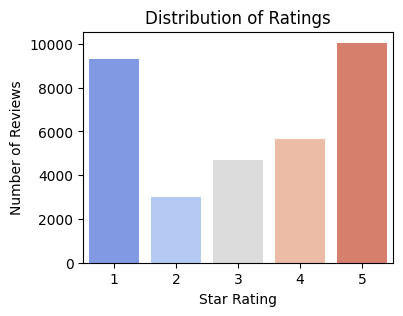

In [57]:
plt.figure(figsize=(4,3))
sns.countplot(x='rating', data=df, palette='coolwarm', order=sorted(df['rating'].unique()))
plt.title("Distribution of Ratings")
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")
plt.show()

#### Convert review time to proper format

In [58]:
def convert_relative_time(text):
    text = text.lower().strip()
    now = datetime.today()
    
    if "day" in text:
        num = int(text.split()[0]) if text[0].isdigit() else 1
        return now - timedelta(days=num)
    elif "week" in text:
        num = int(text.split()[0]) if text[0].isdigit() else 1
        return now - timedelta(weeks=num)
    elif "month" in text:
        num = int(text.split()[0]) if text[0].isdigit() else 1
        return now - relativedelta(months=num)
    elif "year" in text:
        num = int(text.split()[0]) if text[0].isdigit() else 1
        return now - relativedelta(years=num)
    else:
        return pd.NaT

In [59]:
df["review_date"] = df["review_time"].apply(convert_relative_time)

In [60]:
df.head()

,store_address,latitude,longitude,rating_count,review_time,review,rating,review_date
0,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1,2025-05-30 18:17:04.318901
1,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4,2025-08-25 18:17:04.323921
2,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1,2025-08-25 18:17:04.323921
3,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5,2025-07-30 18:17:04.323921
4,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1,2025-06-30 18:17:04.323921


In [61]:
df = df.drop(columns=["review_time"], errors="ignore")

In [62]:
df.head()

,store_address,latitude,longitude,rating_count,review,rating,review_date
0,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",Why does it look like someone spit on my food?...,1,2025-05-30 18:17:04.318901
1,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",It'd McDonalds. It is what it is as far as the...,4,2025-08-25 18:17:04.323921
2,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",Made a mobile order got to the speaker and che...,1,2025-08-25 18:17:04.323921
3,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5,2025-07-30 18:17:04.323921
4,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240","I repeat my order 3 times in the drive thru, a...",1,2025-06-30 18:17:04.323921


### Data Preprocessing

#### Label reviews using rating

In [63]:
def label_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating == 3:
        return "neutral"
    elif rating in [4, 5]:
        return "positive"
    else:
        return "unknown"  

df["sentiment"] = df["rating"].apply(label_sentiment)

In [64]:
print(df["sentiment"].value_counts())

sentiment
positive    15705
negative    12325
neutral      4706
Name: count, dtype: int64


In [65]:
df.head()

,store_address,latitude,longitude,rating_count,review,rating,review_date,sentiment
0,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",Why does it look like someone spit on my food?...,1,2025-05-30 18:17:04.318901,negative
1,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",It'd McDonalds. It is what it is as far as the...,4,2025-08-25 18:17:04.323921,positive
2,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",Made a mobile order got to the speaker and che...,1,2025-08-25 18:17:04.323921,negative
3,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5,2025-07-30 18:17:04.323921,positive
4,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240","I repeat my order 3 times in the drive thru, a...",1,2025-06-30 18:17:04.323921,negative


In [66]:
sentiment_map = {"negative": 0, "neutral": 1, "positive": 2}
df["sentiment_numeric"] = df["sentiment"].map(sentiment_map)

print(df[["sentiment", "sentiment_numeric"]].head())

  sentiment  sentiment_numeric
0  negative                  0
1  positive                  2
2  negative                  0
3  positive                  2
4  negative                  0


#### Clean review column

In [70]:
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = word_tokenize(text)
    words = [w for w in words if w not in stop_words or w in ['not', 'no']]
    
    return ' '.join(words)

df["clean_review"] = df["review"].apply(clean_text)

print(df[["review", "clean_review"]].head())

                                              review  \
0  Why does it look like someone spit on my food?...   
1  It'd McDonalds. It is what it is as far as the...   
2  Made a mobile order got to the speaker and che...   
3  My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...   
4  I repeat my order 3 times in the drive thru, a...   

                                        clean_review  
0  look like someone spit food normal transaction...  
1  itd mcdonalds far food atmosphere go staff mak...  
2  made mobile order got speaker checked line not...  
3  mc crispy chicken sandwich ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï...  
4  repeat order times drive thru still manage mes...  


### Model Training

#### Train-Test split

In [89]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment_numeric'], test_size=0.2, random_state=42, stratify=df['sentiment_numeric'])

#### TF-IDF Vectorization

In [90]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

#### VADER

In [91]:
sia = SentimentIntensityAnalyzer()

In [ ]:
def vader_features(text_series):
    features = []
    for text in text_series:
        scores = sia.polarity_scores(str(text))
        features.append([scores['compound'], scores['pos'], scores['neu'], scores['neg']])
    return np.array(features)

X_train_vader = vader_features(X_train)
X_test_vader = vader_features(X_test)

#### Combine TF-IDF and VADER features


In [93]:
from scipy.sparse import hstack
X_train_combined = hstack([X_train_tfidf, X_train_vader])
X_test_combined = hstack([X_test_tfidf, X_test_vader])

#### Train Models


In [96]:
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, C=1.0, solver='liblinear')

In [97]:
logreg.fit(X_train_combined, y_train)

c:\Users\arpit\Desktop\DS_Course\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [98]:
y_pred_logreg = logreg.predict(X_test_combined)

### Model Evaluation

In [99]:
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

Logistic Regression Accuracy: 0.8191814294441051
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      2465
           1       0.55      0.47      0.51       941
           2       0.88      0.87      0.87      3142

    accuracy                           0.82      6548
   macro avg       0.75      0.74      0.75      6548
weighted avg       0.81      0.82      0.82      6548



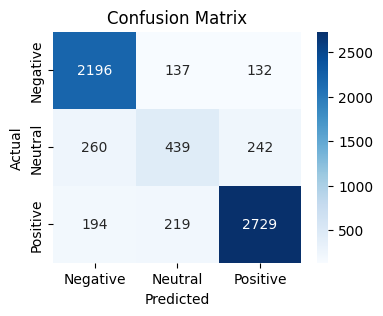

In [100]:
cm = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Model Prediction on unseen data (London McDonald's Reviews)

In [101]:
df_london=pd.read_csv("../data/McDonald_s_Reviews_London.csv",encoding="latin1")

In [102]:
df_london.head()

,CommentDate,Date,RestaurantName,Comment,Address
0,2023-07-07,2023-09-15,McDonald's,Very good lovely staff amazing burgers rubbish...,25/27 Shaftesbury Ave Piccadilly Circus London...
1,2022-02-23,2023-09-15,McDonald's,"The worst McDonalds in central London, coming ...",25/27 Shaftesbury Ave Piccadilly Circus London...
2,2018-07-28,2023-09-15,McDonald's,As an American with a British name but no Brit...,25/27 Shaftesbury Ave Piccadilly Circus London...
3,2018-07-26,2023-09-15,McDonald's,Needed my Americana dose and access to a restr...,25/27 Shaftesbury Ave Piccadilly Circus London...
4,2018-01-08,2023-09-15,McDonald's,Located across the street from the Palace Thea...,25/27 Shaftesbury Ave Piccadilly Circus London...


In [ ]:
df_london.info()
print(df_london.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CommentDate     336 non-null    object
 1   Date            336 non-null    object
 2   RestaurantName  336 non-null    object
 3   Comment         336 non-null    object
 4   Address         323 non-null    object
dtypes: object(5)
memory usage: 13.3+ KB
CommentDate        0
Date               0
RestaurantName     0
Comment            0
Address           13
dtype: int64


In [104]:
df_london["clean_review"] = df_london["Comment"].apply(clean_text)

print(df_london[["Comment", "clean_review"]].head())

                                             Comment  \
0  Very good lovely staff amazing burgers rubbish...   
1  The worst McDonalds in central London, coming ...   
2  As an American with a British name but no Brit...   
3  Needed my Americana dose and access to a restr...   
4  Located across the street from the Palace Thea...   

                                        clean_review  
0  good lovely staff amazing burgers rubbish unif...  
1  worst mcdonalds central london coming back wor...  
2  american british name no british ancestry neve...  
3  needed americana dose access restroom tried ch...  
4  located across street palace theatre mcdonalds...  


In [105]:
X_new = tfidf.transform(df_london['clean_review'])

In [107]:
X_tfidf_london = tfidf.transform(df_london["clean_review"])
X_vader_london = vader_features(df_london["clean_review"])
X_combined_london = hstack([X_tfidf_london, X_vader_london])



In [108]:
y_pred_london = logreg.predict(X_combined_london)

In [110]:
mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
pred_labels = [mapping[i] for i in y_pred_london]

In [114]:
for review, label in list(zip(df_london['Comment'], pred_labels))[:10]:
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {label}")
    print("-"*50)


Review: Very good lovely staff amazing burgers rubbish uniform looks they came out of the dark bin and one man called alex very nice
Predicted Sentiment: positive
--------------------------------------------------
Review: The worst McDonalds in central London, coming back here ONLY because I work next door. Twice came back with burgers hard as a stone - complained to the manager they never show a "sorry attitude" and staff being ignorant. I've been advised and reminded by my colleagues again to check the food before I leave today Â - the fries were not cooked inside - mash like coming out - broken in pieces - and oil - dry and dark from the outside! - when asked to exch them they Â again gave me the same horrible fries and I obviously said its no point so I waited a long time for the new fries. Why is that? I love fresh McDonald's
Predicted Sentiment: negative
--------------------------------------------------
Review: As an American with a British name but no British ancestry who has n

In [112]:
label_counts = Counter(pred_labels)
print(label_counts)

Counter({'positive': 175, 'negative': 129, 'neutral': 32})


In [122]:
df_london["Predicted Sentiment"] = pred_labels  

In [ ]:
df_london = df_london.drop(columns=["clean_review",], errors="ignore")

In [125]:
df_london.head()

,CommentDate,Date,RestaurantName,Comment,Address,Predicted Sentiment
0,2023-07-07,2023-09-15,McDonald's,Very good lovely staff amazing burgers rubbish...,25/27 Shaftesbury Ave Piccadilly Circus London...,positive
1,2022-02-23,2023-09-15,McDonald's,"The worst McDonalds in central London, coming ...",25/27 Shaftesbury Ave Piccadilly Circus London...,negative
2,2018-07-28,2023-09-15,McDonald's,As an American with a British name but no Brit...,25/27 Shaftesbury Ave Piccadilly Circus London...,negative
3,2018-07-26,2023-09-15,McDonald's,Needed my Americana dose and access to a restr...,25/27 Shaftesbury Ave Piccadilly Circus London...,neutral
4,2018-01-08,2023-09-15,McDonald's,Located across the street from the Palace Thea...,25/27 Shaftesbury Ave Piccadilly Circus London...,positive


In [ ]:
df_london.to_csv("london_sentiment_predictions.csv", index=False)

### Visualization

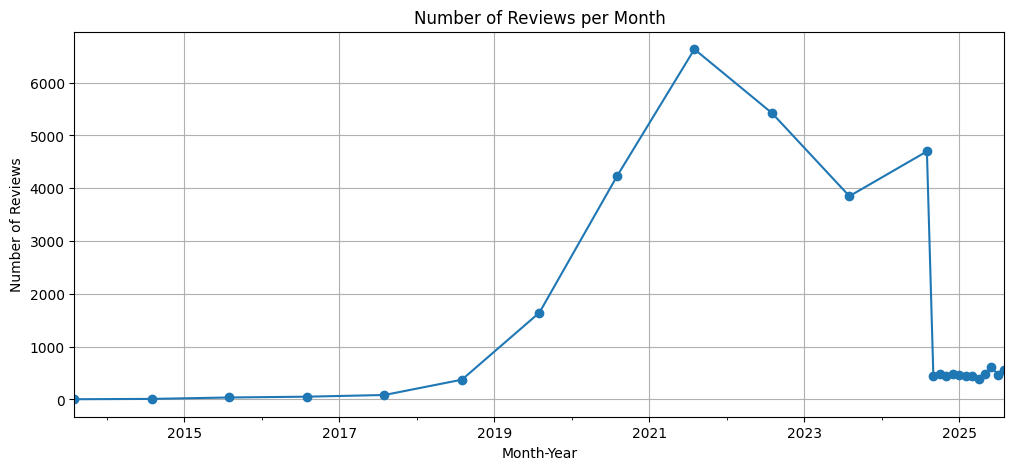

In [28]:
df['review_date'] = pd.to_datetime(df['review_date'])
df['year_month'] = df['review_date'].dt.to_period('M')

monthly_counts = df.groupby('year_month').size()

monthly_counts.plot(kind='line', figsize=(12,5), marker='o')
plt.title("Number of Reviews per Month")
plt.xlabel("Month-Year")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.show()


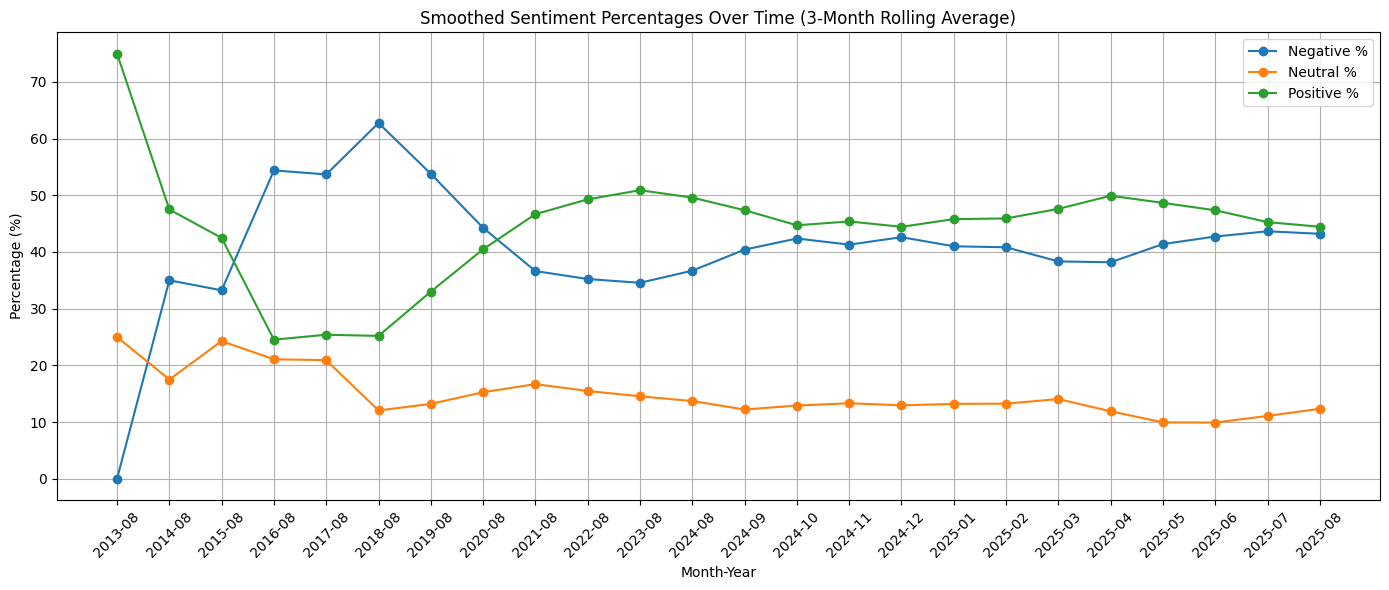

In [30]:
monthly_counts = df.groupby(df['review_date'].dt.to_period('M')).size()
sentiment_counts = df.groupby([df['review_date'].dt.to_period('M'), 'sentiment']).size().unstack(fill_value=0)
sentiment_percentage = (sentiment_counts.T / monthly_counts).T * 100

smoothed_percentage = sentiment_percentage.rolling(window=3, min_periods=1).mean()

plt.figure(figsize=(14,6))
for sentiment in smoothed_percentage.columns:
    plt.plot(smoothed_percentage.index.astype(str),
             smoothed_percentage[sentiment],
             marker='o',
             label=f"{sentiment.capitalize()} %")

plt.title("Smoothed Sentiment Percentages Over Time (3-Month Rolling Average)")
plt.xlabel("Month-Year")
plt.ylabel("Percentage (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
agg_df = df.groupby(['store_address', 'latitude ', 'longitude']).sentiment.value_counts(normalize=True).unstack().fillna(0)
agg_df['positive_percentage'] = agg_df['positive'] * 100
agg_df = agg_df.reset_index()


In [173]:
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)
marker_cluster = MarkerCluster().add_to(m)

for idx, row in agg_df.iterrows():
    popup_text = (f"<b>{row['store_address']}</b><br>"
                  f"Positive: {row['positive_percentage']:.1f}%<br>"
                  f"Negative: {row.get('negative',0)*100:.1f}%<br>"
                  f"Neutral: {row.get('neutral',0)*100:.1f}%")
    
    folium.CircleMarker(
        location=[row['latitude '], row['longitude']],
        radius=7 + row['positive_percentage'] / 15,  
        popup=popup_text,
        color='green' if row['positive_percentage'] > 60 else 'orange' if row['positive_percentage'] > 40 else 'red',
        fill=True,
        fill_color='green' if row['positive_percentage'] > 60 else 'orange' if row['positive_percentage'] > 40 else 'red',
        fill_opacity=0.6
    ).add_to(marker_cluster)


In [174]:
from folium import FeatureGroup

fg = FeatureGroup(name="store_address").add_to(m)

for idx, row in agg_df.iterrows():
    folium.Marker(
        location=[row['latitude '], row['longitude']],
        popup=row['store_address'],
        tooltip=row['store_address']
    ).add_to(fg)

Search(
    layer=fg,
    search_label="popup",  
    placeholder="Search store...",
    collapsed=False
).add_to(m)


In [176]:
m.save("../output/review_map.html")